# Using function

In [1]:
from importlib import reload
import learn_class as lc
from Learning import utils as us
from experiments import *
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import json
import seaborn as sns
sns.set_theme()
import random

In [2]:
np.random.seed(0)
random.seed(0)
code_dir = r'C:\\Users\\theod\\PycharmProjects\\climate_policy_thesis\\climate_policy_RL'
proj_dir = r'C:\\Users\\theod\\Desktop\\UCL\\Machine Learning\\Project'
models = os.path.join(proj_dir, "models",)

# PPO

In [3]:
results = []
for seed in range(3):
    ppo = Noisy_Learn(fixed_test=True, seed=seed, noise=1e-5)
    ppo.set_agent("PPO", os.path.join(models, f"fix_noise_ppo_policy_net_.{seed}.pt"), os.path.join(models, f"fix_noise_ppo_value_net_.{seed}.pt"))
    print(ppo.env.print_params())
    results.append()
    plt.show()
print(results, np.mean(results), np.std(results))

[50.00088202617299, 50.00020007860419, 0.03000029362139523, 8.570192044547171e-05, 4000074702319.6055, 1.9999804544424025, 47000446541.55624, 146.9997775049038]


 25%|███████████████████████████▍                                                                                  | 498/2000 [02:46<07:46,  3.22it/s]

Noise now: 0.0001


 50%|██████████████████████████████████████████████████████▉                                                       | 999/2000 [05:22<07:23,  2.26it/s]

Noise now: 0.001


 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 1499/2000 [08:15<02:33,  3.27it/s]

Noise now: 0.01


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [11:14<00:00,  2.30it/s]

Noise now: 0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [11:15<00:00,  2.96it/s]


[50.00081217268183, 49.999694121793176, 0.029999841548474317, 8.569908046589081e-05, 4000034616305.1733, 1.9999539692260624, 47000820061.52918, 146.9988810258557]


 25%|███████████████████████████▌                                                                                  | 502/2000 [00:35<01:48, 13.86it/s]

Noise now: 0.0001


 50%|██████████████████████████████████████████████████████▌                                                      | 1000/2000 [01:11<01:25, 11.75it/s]

Noise now: 0.001


 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 1503/2000 [01:50<00:31, 15.97it/s]

Noise now: 0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:29<00:00, 13.40it/s]


Noise now: 0.1
[49.9997916210763, 49.999971866586385, 0.029999359141171297, 8.57014057120828e-05, 3999928262576.5923, 1.999983165052687, 47000236354.26606, 146.9981694265127]


 25%|███████████████████████████▍                                                                                  | 498/2000 [03:45<10:59,  2.28it/s]

Noise now: 0.0001


 50%|██████████████████████████████████████████████████████▊                                                       | 997/2000 [07:40<07:52,  2.12it/s]

Noise now: 0.001


 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 1499/2000 [11:30<04:24,  1.89it/s]

Noise now: 0.01


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [15:30<00:00,  1.90it/s]

Noise now: 0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [15:31<00:00,  2.15it/s]
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [ ]:
with open("ppo_noise.json", "w") as f:
    json.dump(results, f)

[50.00882026172984, 50.00200078604183, 0.030002936213952315, 8.571920445471715e-05, 4000747023196.0596, 1.9998045444240247, 47004465415.56237, 146.997775049038]


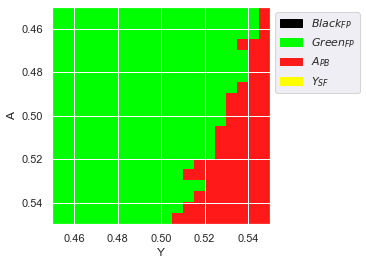

[50.00812172681831, 49.99694121793175, 0.029998415484743208, 8.569080465890811e-05, 4000346163051.73, 1.999539692260624, 47008200615.291824, 146.98881025855684]


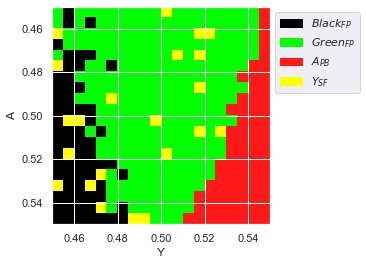

[49.99791621076297, 49.99971866586387, 0.029993591411712994, 8.571405712082803e-05, 3999282625765.9224, 1.9998316505268687, 47002363542.66064, 146.98169426512686]


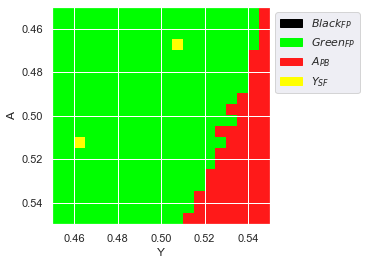

[0.7825, 0.6025, 0.8075] 0.7308333333333333 0.0913175168786848


In [22]:
results = []
for seed in range(3):
    ppo = Noisy_Learn(fixed_test=True, seed=seed, noise=1e-5)
    ppo.set_agent("PPO", os.path.join(models, "default",f"2ppo_policy_net_{seed}.pt"), os.path.join(models, "default", f"2ppo_critic_net_{seed}.pt"))
    print(ppo.env.print_params())
    
    plt.show()
print(results, np.mean(results), np.std(results))
with open("ppo_no_noise.json") as f:
    json.dump(results, f)

# DQN

[50.00882026172984, 50.00200078604183, 0.030002936213952315, 8.571920445471715e-05, 4000747023196.0596, 1.9998045444240247, 47004465415.56237, 146.997775049038]


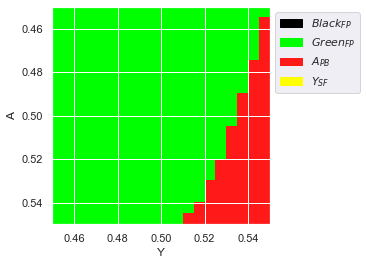

[50.00812172681831, 49.99694121793175, 0.029998415484743208, 8.569080465890811e-05, 4000346163051.73, 1.999539692260624, 47008200615.291824, 146.98881025855684]


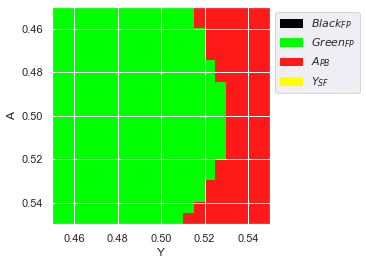

[49.99791621076297, 49.99971866586387, 0.029993591411712994, 8.571405712082803e-05, 3999282625765.9224, 1.9998316505268687, 47002363542.66064, 146.98169426512686]


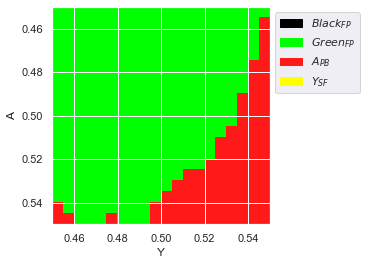

[0.83, 0.7325, 0.77] 0.7775 0.04015594601052249


In [9]:
results = []
for seed in range(3):
    dqn = Noisy_Learn(fixed_test=True, seed=seed, noise=1e-3)
    dqn.set_agent("DQN", os.path.join(models, "default", f"dqn_target_net_{seed}.pt"))
    print(dqn.env.print_params())
    results.append(dqn.test_agent(400))
    plt.show()
print(results, np.mean(results), np.std(results))

[50.00882026172984, 50.00200078604183, 0.030002936213952315, 8.571920445471715e-05, 4000747023196.0596, 1.9998045444240247, 47004465415.56237, 146.997775049038]


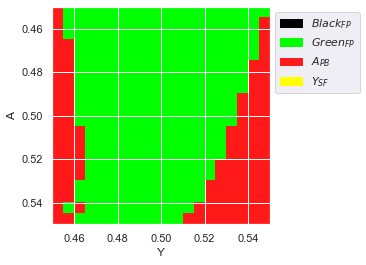

[50.00812172681831, 49.99694121793175, 0.029998415484743208, 8.569080465890811e-05, 4000346163051.73, 1.999539692260624, 47008200615.291824, 146.98881025855684]


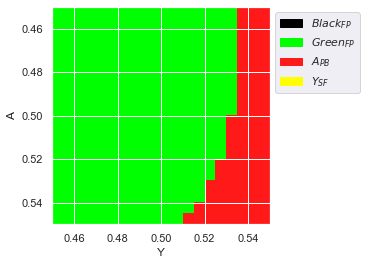

[49.99791621076297, 49.99971866586387, 0.029993591411712994, 8.571405712082803e-05, 3999282625765.9224, 1.9998316505268687, 47002363542.66064, 146.98169426512686]


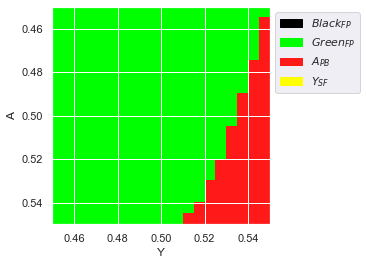

[0.725, 0.7925, 0.83] 0.7825000000000001 0.043445367992456914


In [10]:
results = []
for seed in range(3):
    dqn = Noisy_Learn(fixed_test=True, seed=seed, noise=1e-3)
    dqn.set_agent("DQN", os.path.join(models, f"fix_noise_dqn_target_net_.{seed}.pt"))
    print(dqn.env.print_params())
    results.append(dqn.test_agent(400))
    plt.show()
print(results, np.mean(results), np.std(results))

# DuelDDQN

[50.00882026172984, 50.00200078604183, 0.030002936213952315, 8.571920445471715e-05, 4000747023196.0596, 1.9998045444240247, 47004465415.56237, 146.997775049038]


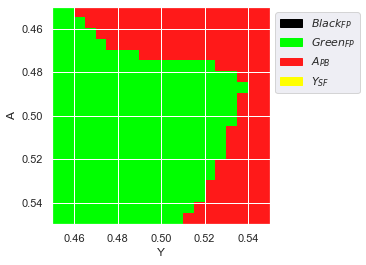

[50.00812172681831, 49.99694121793175, 0.029998415484743208, 8.569080465890811e-05, 4000346163051.73, 1.999539692260624, 47008200615.291824, 146.98881025855684]


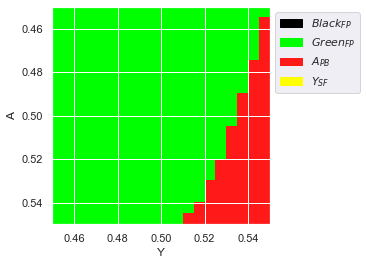

[49.99791621076297, 49.99971866586387, 0.029993591411712994, 8.571405712082803e-05, 3999282625765.9224, 1.9998316505268687, 47002363542.66064, 146.98169426512686]


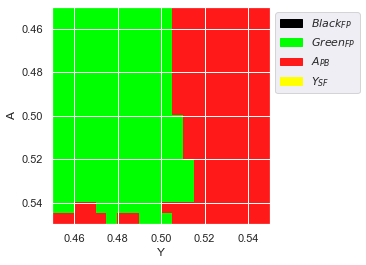

[0.635, 0.83, 0.555] 0.6733333333333333 0.11549410759380273


In [15]:
results = []
for seed in range(3):
    dqn = Noisy_Learn(fixed_test=True, seed=seed, noise=1e-3)
    dqn.set_agent("DuelDDQN", os.path.join(models, "default", f"2duelddqn_target_net_{seed}.pt"))
    print(dqn.env.print_params())
    results.append(dqn.test_agent(400))
    plt.show()
print(results, np.mean(results), np.std(results))

[50.00882026172984, 50.00200078604183, 0.030002936213952315, 8.571920445471715e-05, 4000747023196.0596, 1.9998045444240247, 47004465415.56237, 146.997775049038]


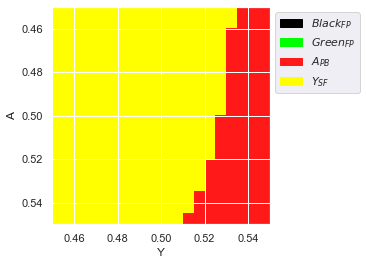

[50.00812172681831, 49.99694121793175, 0.029998415484743208, 8.569080465890811e-05, 4000346163051.73, 1.999539692260624, 47008200615.291824, 146.98881025855684]


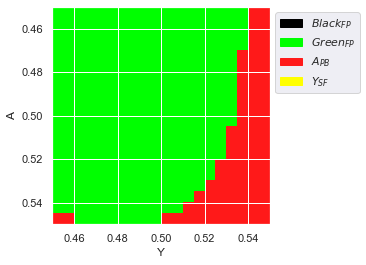

[49.99791621076297, 49.99971866586387, 0.029993591411712994, 8.571405712082803e-05, 3999282625765.9224, 1.9998316505268687, 47002363542.66064, 146.98169426512686]


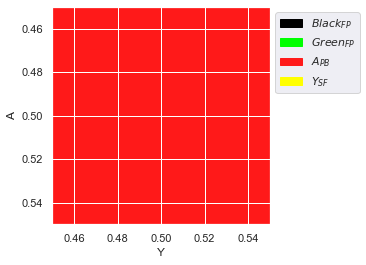

[0.0, 0.79, 0.0] 0.26333333333333336 0.372409571424915


In [18]:
results = []
for seed in range(3):
    dqn = Noisy_Learn(fixed_test=True, seed=seed, noise=1e-3)
    dqn.set_agent("DuelDDQN", os.path.join(models, f"fix_noisy_duelddqn_target_net_{seed}.pt"))
    print(dqn.env.print_params())
    results.append(dqn.test_agent(400))
    plt.show()
print(results, np.mean(results), np.std(results))

# A2C

[50.00882026172984, 50.00200078604183, 0.030002936213952315, 8.571920445471715e-05, 4000747023196.0596, 1.9998045444240247, 47004465415.56237, 146.997775049038]


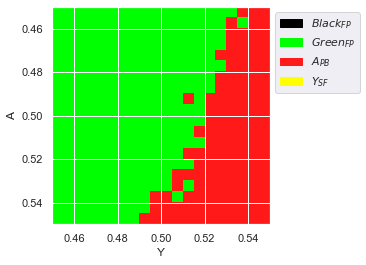

[50.00812172681831, 49.99694121793175, 0.029998415484743208, 8.569080465890811e-05, 4000346163051.73, 1.999539692260624, 47008200615.291824, 146.98881025855684]


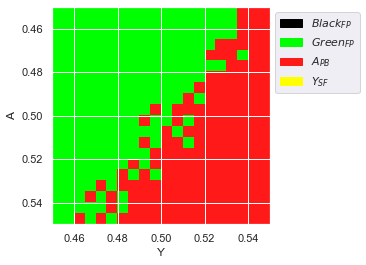

[49.99791621076297, 49.99971866586387, 0.029993591411712994, 8.571405712082803e-05, 3999282625765.9224, 1.9998316505268687, 47002363542.66064, 146.98169426512686]


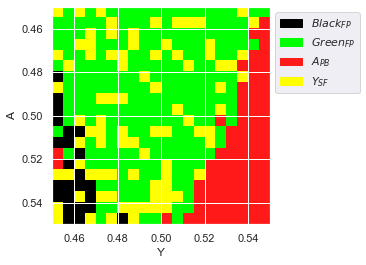

[0.675, 0.56, 0.525] 0.5866666666666668 0.06407460928913696


In [19]:
results = []
for seed in range(3):
    ppo = Noisy_Learn(fixed_test=True, seed=seed, noise=1e-5)
    ppo.set_agent("A2C", os.path.join(models, f"fix_noisy_a2c_actor_{seed}.pt"), os.path.join(models, f"fix_noisy_a2c_critic_{seed}.pt"))
    print(ppo.env.print_params())
    results.append(ppo.test_agent(400))
    plt.show()
print(results, np.mean(results), np.std(results))

[50.00882026172984, 50.00200078604183, 0.030002936213952315, 8.571920445471715e-05, 4000747023196.0596, 1.9998045444240247, 47004465415.56237, 146.997775049038]


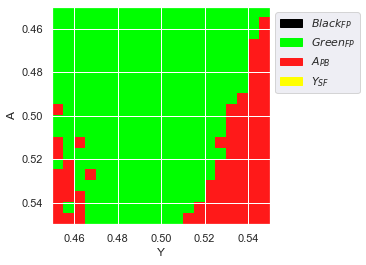

[50.00812172681831, 49.99694121793175, 0.029998415484743208, 8.569080465890811e-05, 4000346163051.73, 1.999539692260624, 47008200615.291824, 146.98881025855684]


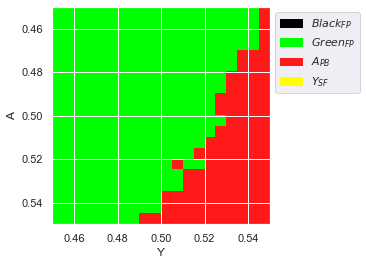

[49.99791621076297, 49.99971866586387, 0.029993591411712994, 8.571405712082803e-05, 3999282625765.9224, 1.9998316505268687, 47002363542.66064, 146.98169426512686]


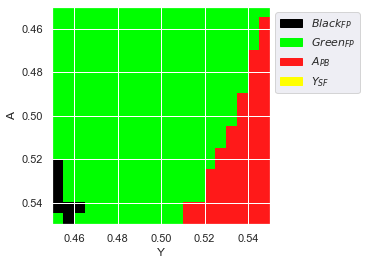

[0.7725, 0.7375, 0.8] 0.77 0.025576682088704675


In [20]:
results = []
for seed in range(3):
    ppo = Noisy_Learn(fixed_test=True, seed=seed, noise=1e-3)
    ppo.set_agent("A2C", os.path.join(models, "default",f"a2c_actor_{seed}.pt"), os.path.join(models, "default", f"a2c_critic_{seed}.pt"))
    print(ppo.env.print_params())
    results.append(ppo.test_agent(400))
    plt.show()
print(results, np.mean(results), np.std(results))